### Loading libs

In [1]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset

from sklearn import cluster, datasets, mixture
# from latentcor import gen_data, get_tps, latentcor

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

### Reading data

In [2]:
# load
data = pd.read_csv('./sim-data-mult/trans_series.csv', index_col=0).to_numpy(dtype="float32")
print(data.shape)

(10000, 500)


In [3]:
# split data
train_data = {'x': data[:9000, :-50], 'y': data[:9000, -50:]}
test_data = {'x': data[9000:, :-50], 'y': data[9000:, -50:]}

In [4]:
class Data(Dataset):
    def __init__(self, data):
        # init
        self.data = data
    def __getitem__(self, index):
        return self.data['x'][index, :], self.data['y'][index, :]
    def __len__(self):
        return self.data['x'].shape[0]

In [5]:
# scale
mu = np.mean(np.concatenate([train_data['x'], train_data['y']], 1))
std = np.std(np.concatenate([train_data['x'], train_data['y']], 1))

train_data['x'] = (train_data['x'] - mu) / std
train_data['y'] = (train_data['y'] - mu) / std
test_data['x'] = (test_data['x'] - mu) / std
test_data['y'] = (test_data['y'] - mu) / std

In [6]:
# calculate covariance
phi = 0.9
sigmasq = 0.0001
n = 500

true_cov = np.zeros((n, n))
row = np.cumprod([1] + [phi]*499)
for i in range(n):
    true_cov[i, :(i+1)] = np.flip(row[:(i+1)])
    true_cov[i, (i+1):] = row[1:(n-i)]
true_cov = true_cov.astype(np.float32)
true_cov = true_cov * sigmasq / (1 - phi**2)

In [7]:
# create data loader for training data
train_dataset = Data(train_data)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

### Define model

In [8]:
for i, data in enumerate(train_loader): break

In [9]:
data[0].shape

torch.Size([256, 450])

In [10]:
class RealNVP(nn.Module):
    def __init__(self, nets1, nett1, mask1, 
                 nets2, nett2, mask2, prior1, prior2, pred_mat, pred_len):
        super(RealNVP, self).__init__()
        
        self.pred_len = pred_len
        self.pred_mat = nn.Parameter(data=pred_mat, requires_grad=False)
        
        self.prior1 = prior1
        self.prior2 = prior2
        
        self.mask1 = nn.Parameter(mask1, requires_grad=False)
        self.t1 = torch.nn.ModuleList([nett1() for _ in range(len(mask1))])
        self.s1 = torch.nn.ModuleList([nets1() for _ in range(len(mask1))])
        
        self.mask2 = nn.Parameter(mask2, requires_grad=False)
        self.t2 = torch.nn.ModuleList([nett2() for _ in range(len(mask2))])
        self.s2 = torch.nn.ModuleList([nets2() for _ in range(len(mask2))])
        
    def g(self, x1, x2):
        # send to latent and predict (with Gaussian)
        z1, z2, _ = self.f(x1, x2)
        z2 = torch.matmul(self.pred_mat, z1.permute(1, 0)).permute(1, 0)
        x1_inv, x2 = z1, z2
        
        for i in range(len(self.t1)):
            x1_ = x1_inv * self.mask1[i]
            s1 = self.s1[i](x1_)
            t1 = self.t1[i](x1_)
            x1_inv = x1_ + (1 - self.mask1[i]) * (x1_inv * torch.exp(s1) + t1)
            
        for i in range(len(self.t1)):
            x2_ = x2 * self.mask2[i]
            x2cond_ = torch.cat([x2_, x1], 1)
            s2 = self.s2[i](x2cond_)
            t2 = self.t2[i](x2cond_)
            x2 = x2_ + (1 - self.mask2[i]) * (x2 * torch.exp(s2) + t2)
            
        return x1_inv, x2

    def f(self, x1, x2):
        log_det_J1, z1 = x1.new_zeros(x1.shape[0]), x1
        for i in reversed(range(len(self.t1))):
            z1_ = self.mask1[i] * z1
            s1 = self.s1[i](z1_)
            t1 = self.t1[i](z1_)
            z1 = (1 - self.mask1[i]) * ((z1 - t1) * torch.exp(-s1)) + z1_
            log_det_J1 -= s1.sum(dim=1)
        
        log_det_J2, z2 = x2.new_zeros(x2.shape[0]), x2
        for i in reversed(range(len(self.t1))):
            z2_ = self.mask2[i] * z2
            z2cond_ = torch.cat([z2_, x1], 1)
            s2 = self.s2[i](z2cond_)
            t2 = self.t2[i](z2cond_)
            z2 = (1 - self.mask2[i]) * ((z2 - t2) * torch.exp(-s2)) + z2_
            log_det_J2 -= s2.sum(dim=1)
        
        return z1, z2, log_det_J1+log_det_J2
    
    def log_prob(self,x1,x2):
        z1, z2, logp = self.f(x1, x2)
        return self.prior1.log_prob(z1) + self.prior2.log_prob(z2) + logp

In [11]:
n = 500
pred_len = 50

nets1 = lambda: nn.Sequential(nn.Linear(450, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 450), 
                             nn.Tanh())
nett1 = lambda: nn.Sequential(nn.Linear(450, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 450))

nets2 = lambda: nn.Sequential(nn.Linear(500, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 50), 
                             nn.Tanh())
nett2 = lambda: nn.Sequential(nn.Linear(500, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 1024), 
                             nn.LeakyReLU(), 
                             nn.Linear(1024, 50))

mask1_x = [0]*((n - pred_len) // 2) + [1]*((n - pred_len) // 2)
mask2_x = [1]*((n - pred_len) // 2) + [0]*((n - pred_len) // 2)
mask1_y = [0]*(pred_len // 2) + [1]*(pred_len // 2)
mask2_y = [1]*(pred_len // 2) + [0]*(pred_len // 2)
masks_x = torch.from_numpy(np.array([mask1_x, mask2_x] * 10).astype(np.float32))
masks_y = torch.from_numpy(np.array([mask1_y, mask2_y] * 10).astype(np.float32))

true_cov = torch.tensor(true_cov)
pred_mat = torch.matmul(true_cov[-pred_len:, :-pred_len], true_cov[:-pred_len, :-pred_len].inverse())
cov_cond = true_cov[-pred_len:, -pred_len:] - torch.matmul(pred_mat, true_cov[:-pred_len, -pred_len:])
prior1 = distributions.MultivariateNormal(torch.zeros(n-pred_len), 
                                          true_cov[:(n-pred_len), :(n-pred_len)])
prior2 = distributions.MultivariateNormal(torch.zeros(pred_len), cov_cond)
# .cuda()
flow = RealNVP(nets1, nett1, masks_x, nets2, nett2, masks_y, prior1, prior2, pred_mat, pred_len)
# flow.to('cuda')

In [ ]:
EPOCHS = 200
TRAIN_STEPS = len(train_loader)

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for epoch in range(EPOCHS):
    iter_count = 0
    train_loss = []
    epoch_time = time.time()
    curr_time = time.time()
    
    for i, (x1, x2) in enumerate(train_loader):
        iter_count += 1
        x1, x2 = x1.cuda(), x2.cuda()
        loss = -flow.log_prob(x1, x2).mean()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        train_loss.append(loss.item())
        if iter_count % 10 == 0:
            print('\titers: {0}, epoch: {1} | loss: {2:.3f}'.format(iter_count, epoch + 1, loss.item()))
            speed = (time.time() - curr_time) / iter_count
            left_time = speed * ((EPOCHS - epoch) * TRAIN_STEPS - i)
            print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
    
    # compute average train loss
    train_loss = np.average(train_loss)
    print("epoch: {}, epoch time: {}, loss: {}".format(epoch+1, time.time() - curr_time, train_loss))

In [ ]:
torch.save(flow.state_dict(), './model.pt')
torch.save(optimizer.state_dict(), './optim.pt')

In [12]:
flow.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [13]:
# flow.to('cpu')
flow.eval()

# pad test data
test_data_padded = {'x': np.copy(test_data['x']), 'y': np.copy(test_data['y'])}
test_data_padded['x'] = torch.tensor(test_data['x'])
test_data_padded['y'] = torch.zeros_like(torch.tensor(test_data['y']))

# predict
# x, y = flow.g(test_data_padded['x'].cuda(), test_data_padded['y'].cuda())
x, y = flow.g(test_data_padded['x'], test_data_padded['y'])

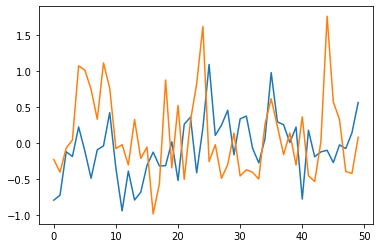

In [19]:
plt.plot(y[200, :].detach().cpu().numpy())
plt.plot(test_data['y'][200, :])

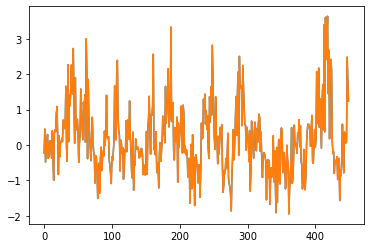

In [15]:
plt.plot(x[0, :].detach().cpu().numpy())
plt.plot(test_data['x'][0, :])

In [ ]:
plt.plot(test_data['y'][0, :])

### Previous trials

In [ ]:
# # predict last 24

# test_data


# for index in range(data_test.shape[0]):
#     # pad with mean
#     sample = np.concatenate((data_test[index, :-24], [np.mean(data_test[index, :-24])]*24))[np.newaxis, :]
#     # iterate prediction step until convergence
#     print('Index: {0}'.format(index))
#     for i in range(5):
#         z, logp = flow.f(torch.from_numpy(sample))
#         print('\tlog prob: {0:.4f}'.format(logp.item()))
#         z = z.detach().numpy()[0]
#         zhat = cov[-24:, :-24] @ np.linalg.inv(cov[:-24, :-24]) @ z[:-24]
#         z = np.concatenate((z[:-24], zhat))
#         sample = flow.g(torch.from_numpy(z[np.newaxis, :])).detach().numpy()
#     # compute confidence band
#     z_upper = np.concatenate((z[:-24], zhat + 2*np.sqrt(np.diag(pred_cov))))
#     z_lower = np.concatenate((z[:-24], zhat - 2*np.sqrt(np.diag(pred_cov))))
#     sample_upper = flow.g(torch.from_numpy(z_lower[np.newaxis, :])).detach().numpy()
#     sample_lower = flow.g(torch.from_numpy(z_upper[np.newaxis, :])).detach().numpy()
#     # save results
#     pred[index, :] = sample[0, :]; pred_lower[index, :] = sample_lower[0, :]; pred_upper[index, :] = sample_upper[0, :]

In [ ]:
# true = scaler.inverse_transform(data_test)[:, -24:]
# pred = scaler.inverse_transform(pred)[:, -24:]
# pred_lower = scaler.inverse_transform(pred_lower)[:, -24:]
# pred_upper = scaler.inverse_transform(pred_upper)[:, -24:]
# print(np.mean((true - pred)**2))

In [ ]:
# index = 1
# plt.plot(true[index, :], color='red')
# plt.plot(pred[index, :], color='blue')
# plt.plot(pred_lower[index, :], color='blue')
# plt.plot(pred_upper[index, :], color='blue')

In [ ]:
# plt.hist(np.mean((true-pred)**2, axis = 1))